In [8]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os, time, json, pickle 
from tqdm import tqdm
from janome.tokenizer import Tokenizer
from wordcloud import WordCloud

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Flatten, LSTM, GRU, Dense, Bidirectional
import math

In [9]:
train = pd.read_csv("C:/Users/ekjot/Downloads/SWA/IN_youtube_trending_data.csv")

with open("C:/Users/ekjot/Downloads/IN_category_id.json", "r") as f:
    cates = json.load(f)
f.close()
    
id2cate = {}
for cate in cates["items"]:
    ids = int(cate["id"])
    snippet = cate["snippet"]
    if ids not in id2cate:
        id2cate[ids] = snippet["title"]
id2cate

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

# Clean Data

In [10]:
use_col = ["publishedAt", "title", "channelTitle", "categoryId", "tags", "view_count"]

train = train[use_col]
train["category"] = train.categoryId.apply(lambda x: id2cate[x] if x in id2cate else "Unknown")
train.drop("categoryId", axis=1, inplace=True)
train.head()

,publishedAt,title,channelTitle,tags,view_count,category
0,2020-08-12T04:31:41Z,Sadak 2 | Official Trailer | Sanjay | Pooja | ...,FoxStarHindi,sadak|sadak 2|mahesh bhatt|vishesh films|pooja...,9885899,Entertainment
1,2020-08-11T09:00:11Z,Kya Baat Aa : Karan Aujla (Official Video) Tan...,Rehaan Records,[None],11308046,Music
2,2020-08-11T07:30:02Z,Diljit Dosanjh: CLASH (Official) Music Video |...,Diljit Dosanjh,clash diljit dosanjh|diljit dosanjh|diljit dos...,9140911,Music
3,2020-08-10T05:30:49Z,Dil Ko Maine Di Kasam Video | Amaal M Ft.Ariji...,T-Series,hindi songs|2020 hindi songs|2020 new songs|t-...,23564512,Music
4,2020-08-11T05:30:13Z,"Baarish (Official Video) Payal Dev,Stebin Ben ...",VYRLOriginals,VYRL Original|Mohsin Khan|Shivangi Joshi|Payal...,6783649,Music


In [11]:

"""
datetime 
"""

train["publishedAt"] = pd.to_datetime(train.publishedAt)
train["year"] = train.publishedAt.dt.year 
train["month"] = train.publishedAt.dt.month 
train["day"] = train.publishedAt.dt.day 
train["datetime"] = train.year.astype(str) + "-" + train.month.astype(str) + "-" + train.day.astype(str)
train.drop(["publishedAt", "year", "month", "day"], axis=1, inplace=True)
train["datetime"] = pd.to_datetime(train.datetime)

train[["datetime"]].dtypes

datetime    datetime64[ns]
dtype: object

In [12]:

'''
tags clensing 
'''


train["split"] = train.tags.apply(lambda x: x.split("|"))

def split_tags(x):
    txt_list = []
    if len(x) > 1 :
        for txt in x:
            txt_list.append(txt)
        return " ".join(txt_list)
    else:
        return ""

train["tags"] = train.split.apply(split_tags)
train.drop("split", axis=1, inplace=True)
train.tags

0        sadak sadak 2 mahesh bhatt vishesh films pooja...
1                                                         
2        clash diljit dosanjh diljit dosanjh diljit dos...
3        hindi songs 2020 hindi songs 2020 new songs t-...
4        VYRL Original Mohsin Khan Shivangi Joshi Payal...
                               ...                        
79653                                                     
79654    Samreen Ali Vlogs samreen ali samreen ali funn...
79655    garena free fire two side gamers free fire two...
79656    soan papdi soan papdi recipe soan papdi recipe...
79657    WORST RATED HOTEL WORST RATED HOTEL VS BEST RA...
Name: tags, Length: 79658, dtype: object

# Visualization 

In [13]:
def viz_transition(df):
    x = df.groupby("datetime").mean().loc[:, ["view_count"]]
    x.plot()
    
    
def viz_categorical_transition(df):
    category = df.category.unique()
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    ax = axes.ravel()
    
    for i, cate in enumerate(category):
        x = df[df.category == cate].groupby("datetime").mean().loc[:, ["view_count"]]
        x.plot(ax=ax[i])
        ax[i].set_title(cate)
        ax[i].set_xlabel("")
        
    plt.tight_layout()

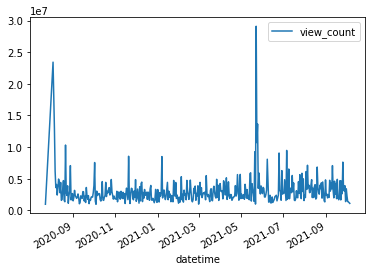

In [14]:
viz_transition(train)

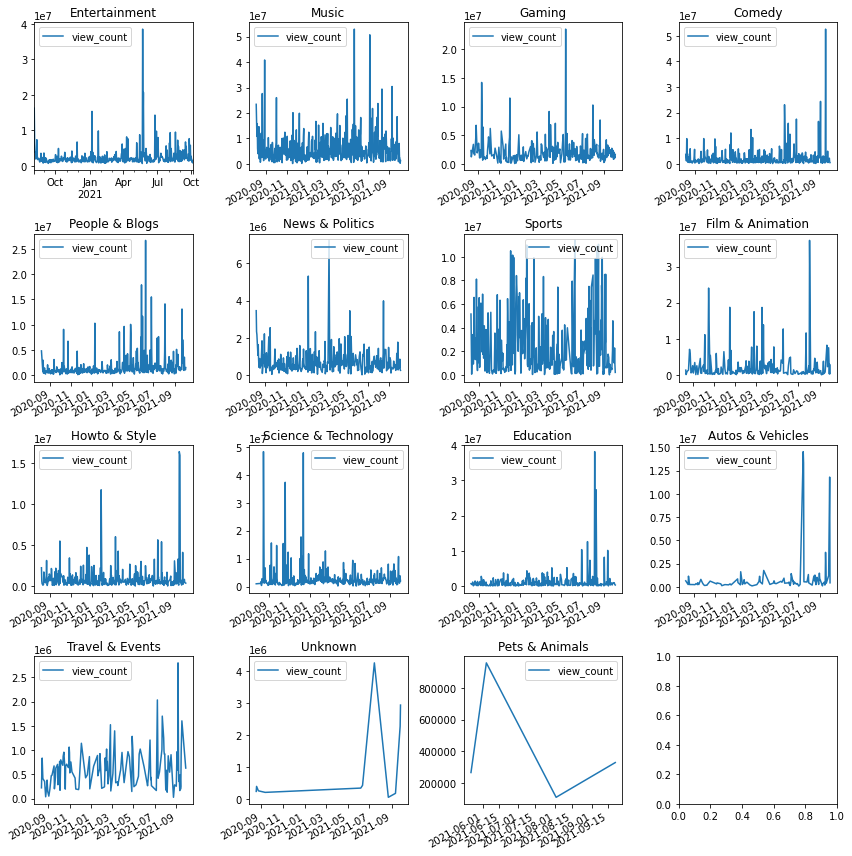

In [15]:
viz_categorical_transition(train)

# Popular Channel

In [16]:

'''
Aggregate the most played data by date.
'''

import warnings 
warnings.simplefilter("ignore")


def find_everytime(df):
    grp = df.groupby("datetime")
    grp = df.loc[grp["view_count"].idxmax(), :]
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(121)
    category = grp.category.value_counts()[:5]
    plt.title("category")
    plt.pie(x=category.values, labels=category.index, counterclock=False, startangle=90)
    plt.legend(category.index)
    
    plt.subplot(122)
    plt.title("channel title")
    channel = grp.channelTitle.value_counts()[:5]
    sns.barplot(x=channel.index, y=channel.values)
    plt.xticks(rotation=90)
    
    plt.show()
    
    return channel.index 
    
    
def find_holiday(df, is_holiday=True):
    dfs = df.copy()
    dfs["week"] = dfs.datetime.dt.dayofweek 
    dfs["holiday"] = dfs.week.apply(lambda x: 1 if x in [5, 6] else 0)
    dfs.drop(["week"], axis=1, inplace=True)
    
    if is_holiday:
        dfs = dfs[dfs.holiday == 1]
    else:
        dfs = dfs[dfs.holiday == 0]
    popular_channel_transition(dfs)
    
    
def popular_channel_transition(df):
    popular = find_everytime(df)
    fig, axes = plt.subplots(3, 2, figsize=(15, 6))
    ax = axes.ravel()
    
    for i, p in enumerate(popular):
        x = df.loc[df.channelTitle == p, ["datetime", "view_count"]]
        x.set_index("datetime").plot(ax=ax[i])
        ax[i].set_title(p)
    plt.tight_layout()
    

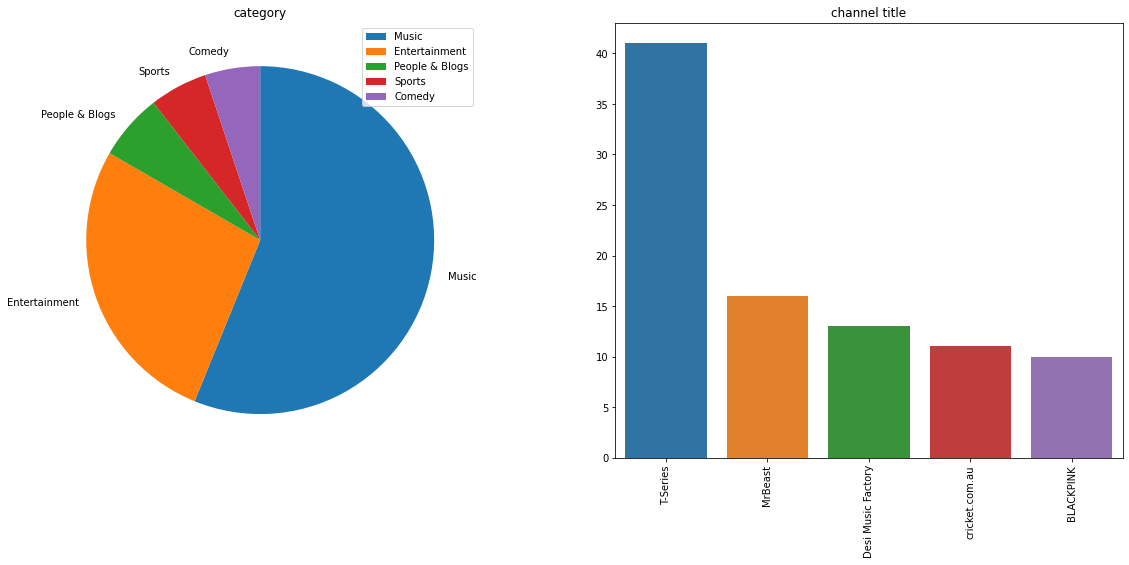

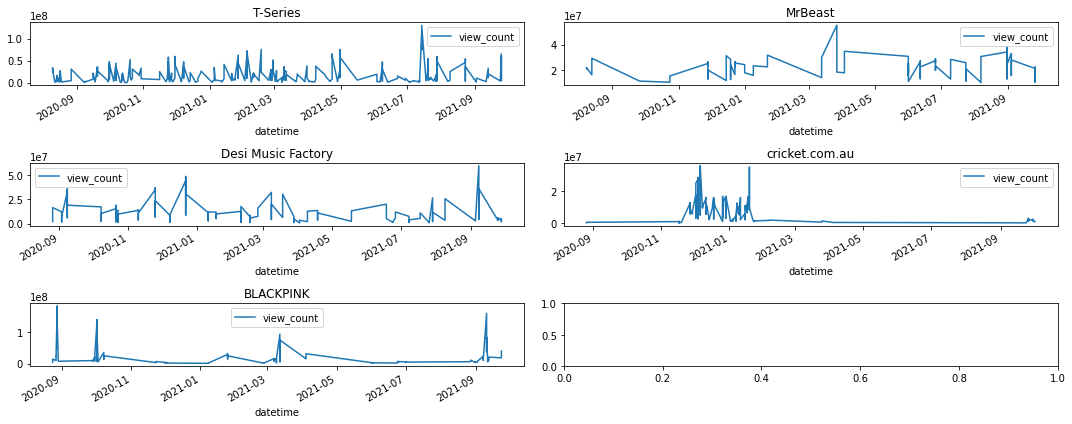

In [17]:

'''
from daily records 
'''

popular_channel_transition(train)

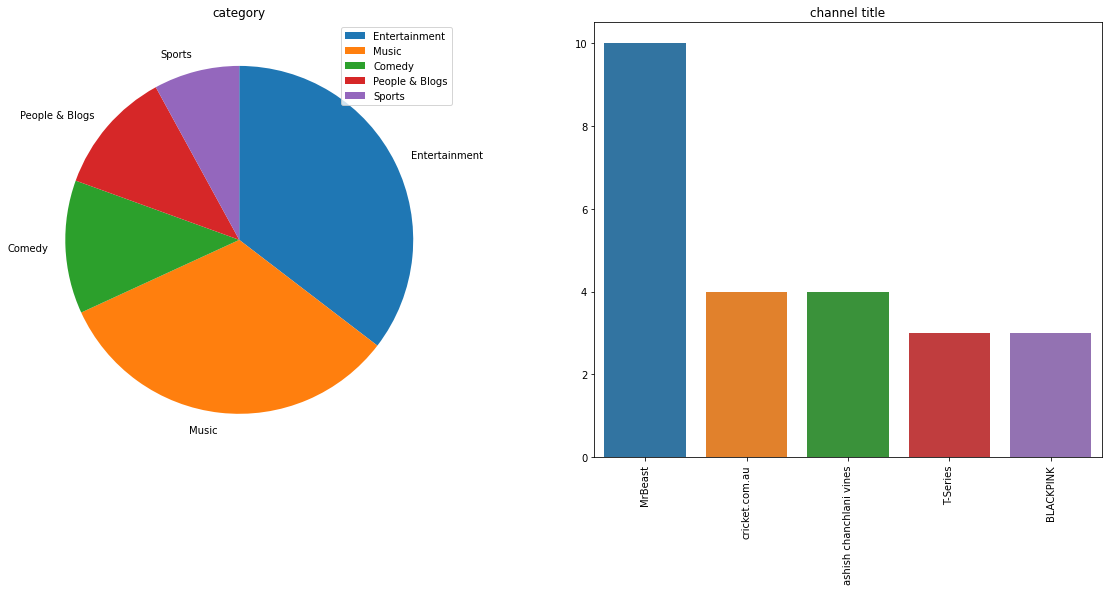

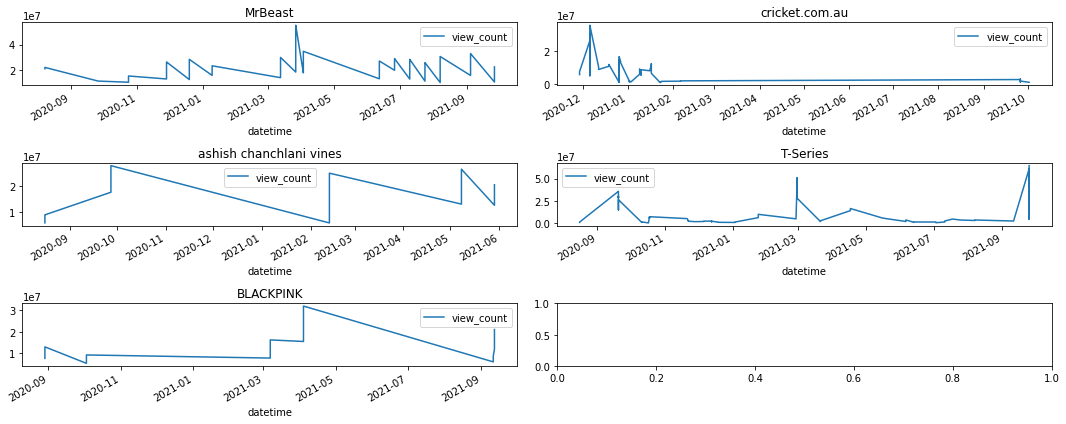

In [18]:

'''
is holiday ?
'''

find_holiday(train)

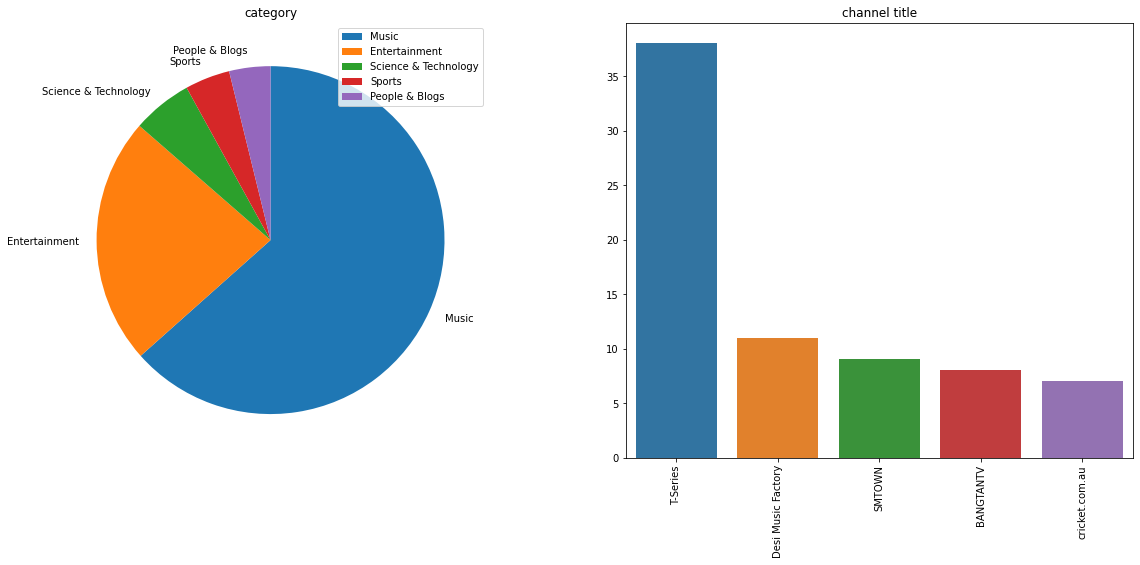

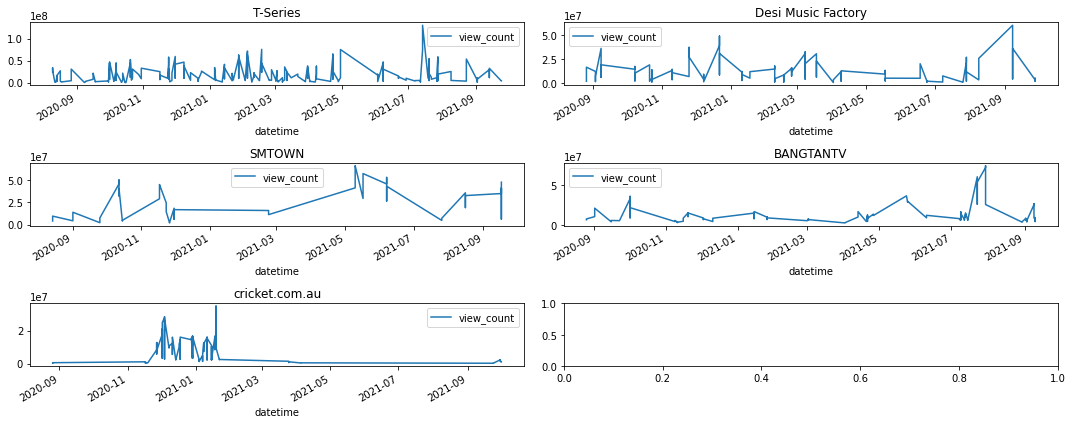

In [19]:

'''
is not holiday ?
'''

find_holiday(train, False)

# Specialized channel

In [20]:

'''
prepare table 
'''

spec = pd.crosstab(train.channelTitle, train.category)
spec.head()

category,Autos & Vehicles,Comedy,Education,Entertainment,Film & Animation,Gaming,Howto & Style,Music,News & Politics,People & Blogs,Pets & Animals,Science & Technology,Sports,Travel & Events,Unknown
channelTitle,,,,,,,,,,,,,,,
#RohiL Fitness Yug,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0
1 Million Views Tamil,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0
1.1 Gaming,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0
10 Mint Records,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0
10TV News Telugu,0,0,0,7,0,0,0,0,28,0,0,0,0,0,0


In [21]:

def find_specialized(cate_name, n=10) -> pd.DataFrame:
    x = spec[[cate_name]].sort_values(cate_name, ascending=False)[:n]
    return x 


def freq_word(cate_name):
    spec_df = find_specialized(cate_name, n=10)
    
#     for spec in spce_df.index:
    tag = train[train.channelTitle.isin(spec_df.index)]["tags"]
    title = train[train.channelTitle.isin(spec_df.index)]["title"]
    x = train[train.channelTitle.isin(spec_df.index)]
    
    fig, axes = plt.subplots(1, 3, figsize = (15, 6))
    ax = axes.ravel()
    for chann in x.channelTitle.unique():
        xx = x.loc[x.channelTitle == chann, ["datetime", "view_count"]]
        xx.set_index("datetime").plot(ax=ax[0], c="g", alpha=max(1.0/len(x.channelTitle.unique()), 0.01)) 
        train[train.category == cate_name].groupby("datetime").mean().plot(ax=ax[0], c="r", alpha=0.1)
        ax[0].legend([])
        ax[0].set_title(f"Transition {cate_name} category 10k")
        
    j_t = Tokenizer()    
    title_list = {} 
    for tt in title:
        for t in j_t.tokenize(tt, wakati=True):
            if t not in title_list:
                title_list[t] = 1
            else:
                title_list[t] += 1 
            
    tag_list = {}
    for tt in tag:
        for t in tt.split():
            if t not in tag_list:
                tag_list[t] = 1 
            else:
                tag_list[t] += 1 
                
    title_cloud = WordCloud(width=1100, height=1500, background_color="white").generate_from_frequencies(title_list)
    ax[1].imshow(title_cloud)
    ax[1].set_title(f"Frquence title {cate_name}")
    
    tag_cloud = WordCloud(width=1100, height=1500, background_color="white").generate_from_frequencies(tag_list)
    ax[2].imshow(tag_cloud)
    ax[2].set_title(f"Frequence tag {cate_name}")
                
    
        

In [22]:
random_category = np.random.choice(spec.columns, 3)
find_specialized(random_category[0])

category,Unknown
channelTitle,
Webdunia Marathi,13
Ashwin,11
Jenni's Hacks,6
Global Citizen,6
Sonam Wangchuk,3
Ankur Narula Ministries,1
SHIVA SHAKTHI,1
SHANKAR MANI,0
SALEEM FAMILY,0


In [23]:
find_specialized(random_category[1])

category,Howto & Style
channelTitle,
Anaysa,173
Village Cooking Channel,168
Cook With Nisha,109
Village Food Channel,98
DIY Queen,90
Madras Samayal,81
Steffi Ulagam,80
SimplyMyStyle!! unni,74
Anishka Khantwaal,73


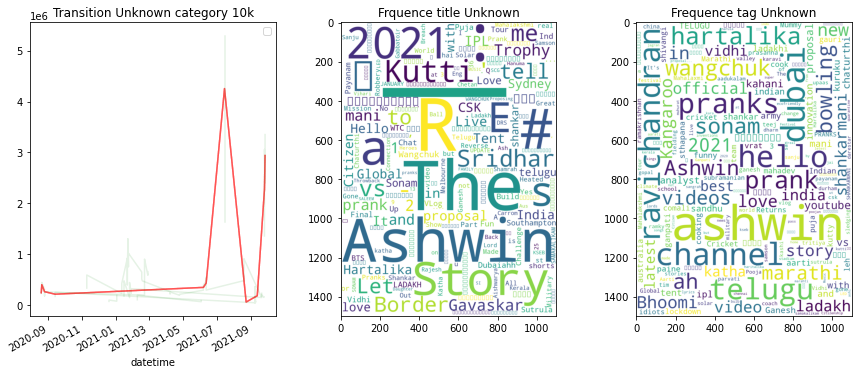

In [24]:
freq_word(random_category[0])

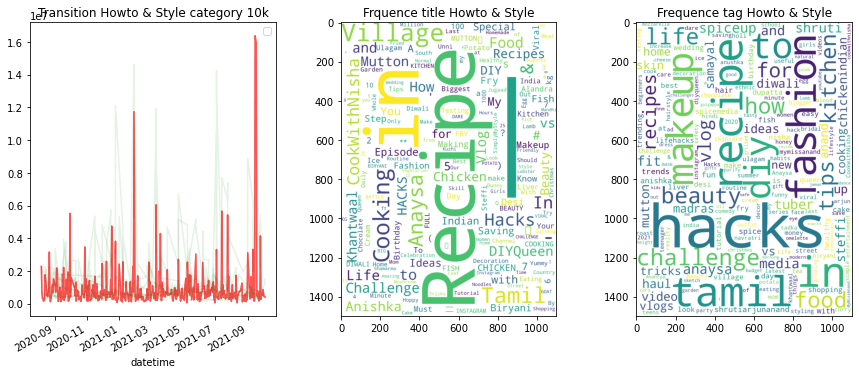

In [25]:
freq_word(random_category[1])

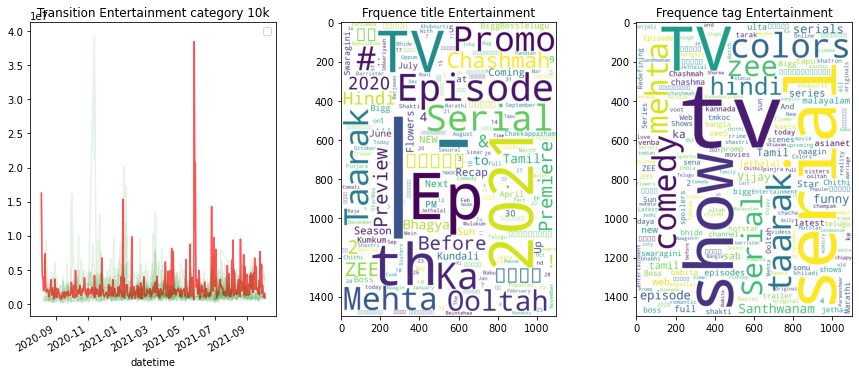

In [26]:
freq_word(random_category[2])

# Search for similar channels

In [27]:

'''
prepare tabular

columns: channelTitle 
index: channelTitle 

'''

s = MinMaxScaler(feature_range=(0.0, 1.0))
s_spec = s.fit_transform(spec)

df_sparse = sp.sparse.csr_matrix(s_spec)
df_sparse = cosine_similarity(df_sparse)
df_sparse = pd.DataFrame(df_sparse, columns=spec.index, index=spec.index)
df_sparse.head()


channelTitle,#RohiL Fitness Yug,1 Million Views Tamil,1.1 Gaming,10 Mint Records,10TV News Telugu,123 GO! CHALLENGE,123 GO! Hindi,123Musix,14 Reels Plus,2 Foreigners In Bollywood,...,zoom,zulfia's recipes,गावरान- एक खरी चव ! - Gavran,चtori Nikki,जोश Talks,मराठी तडका,জোশ Talks,ਪੰਜਾਬੀ ਲੋਕ Punjabi Lok,ಉದ್ಯೋಗ ಮಿತ್ರ,ജോഷ് Talks
channelTitle,,,,,,,,,,,,,,,,,,,,,
#RohiL Fitness Yug,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0
1 Million Views Tamil,0.0,1.0,0.0,0.0,0.0,1.0,0.00000,0.000000,0.0,0.00000,...,0.00000,1.0,1.0,1.0,0.93618,1.0,1.0,0.000000,0.0,1.0
1.1 Gaming,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0
10 Mint Records,0.0,0.0,0.0,1.0,0.0,0.0,0.00000,0.429619,0.0,0.00000,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0
10TV News Telugu,0.0,0.0,0.0,0.0,1.0,0.0,0.02225,0.000000,0.0,0.02225,...,0.02225,0.0,0.0,0.0,0.00000,0.0,0.0,0.999752,0.0,0.0


In [28]:

'''
Prepare a function to search from the table above
'''

def find_similar_channel(channel, n=10):
    x = df_sparse[[channel]].sort_values(channel, ascending=False)[1:n+1]
    return x 

def similar_channel_transition(channel):
    sim_chan = find_similar_channel(channel).index
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ax = axes.ravel()
    for chan in sim_chan:
        x = train.loc[train.channelTitle == chan, ["datetime", "view_count"]]
        x.set_index("datetime").plot(ax=ax[0], alpha=0.2, c="g")
    train.loc[train.channelTitle == channel, ["datetime", "view_count"]]
    train.set_index("datetime").plot(ax=ax[1], alpha=0.2, c="r")
        
    ax[0].set_title(f"{channel} similar for transition 10k")
    ax[0].legend([])
    ax[1].set_title("current channel transition")
    ax[1].legend([])

In [29]:
random_channel = np.random.choice(train.channelTitle, 3)
find_similar_channel(random_channel[0])

channelTitle,Sky Sports Cricket
channelTitle,
Shoaib Akhtar,1.0
Aakash Chopra,1.0
ICC,1.0
Roland Garros,1.0
OutlookMagazine,1.0
Struggle Jeet,1.0
Cricket SuperFans,1.0
Man City,1.0
England & Wales Cricket Board,1.0


In [30]:
find_similar_channel(random_channel[1])

channelTitle,UNBOXINg dude
channelTitle,
Sunita Xpress,1.0
Fondant cakes,1.0
Food N Travel by Ebbin Jose,1.0
Food Version,1.0
Foodie Incarnate,1.0
Foodies Street,1.0
SumanTv Spiritual,1.0
Fresh Food,1.0
Fukra Insaan,1.0


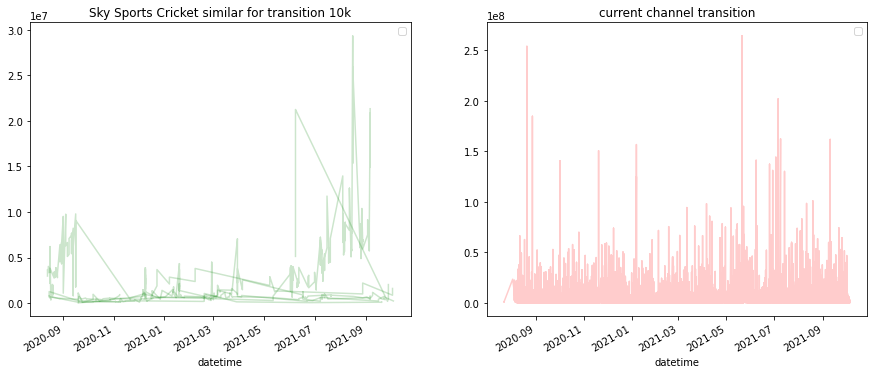

In [31]:
similar_channel_transition(random_channel[0])

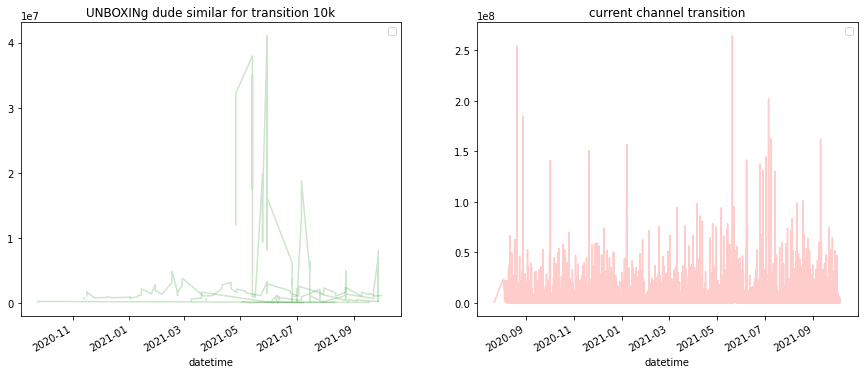

In [32]:
similar_channel_transition(random_channel[1])

The similarity of the categories is high, but on the contrary, the correlation with the number of views is not so noticeable.

# Prediction categorical tomorrow

In [33]:

df_train = train.pivot_table(index="category", 
                             columns="datetime",
                             values="view_count", 
                             aggfunc="sum",
                             fill_value=0)
df_train.head()

datetime,2020-07-23,2020-08-03,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,...,2021-09-26,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-02,2021-10-03,2021-10-04,2021-10-05
category,,,,,,,,,,,,,,,,,,,,,
Autos & Vehicles,0,0,0,0,1322871,0,0,0,0,0,...,0,2432081,0,0,58984348,448548,0,0,0,0
Comedy,0,0,3650769,0,4388511,68846408,0,15280254,9333868,2168579,...,6242877,68872627,4768231,0,20966175,34057571,15237627,2758910,1317844,0
Education,0,0,0,0,0,0,0,2075745,0,4518185,...,5724222,3024224,7828554,4936367,8939946,2287407,7466675,1285661,379999,608453
Entertainment,0,0,64966207,27776858,19307432,78132281,48441041,59331176,136696964,625307126,...,339504020,123224651,557185539,92987837,245649744,107646022,47911548,72860993,34014486,844485
Film & Animation,0,0,0,0,0,0,0,0,6438145,257878,...,0,45021837,0,927712,17301843,2399925,0,0,0,0


In [34]:
print(f"span datetime {len(df_train.columns)} days")
print(f"unique categorical length {len(df_train.index)}")

span datetime 429 days
unique categorical length 15


In [35]:

'''
Model structure 

metrics functions 

'''


def build_model(input_shape=(427, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))    
    model.add(Flatten())
    model.add(Dense(64, activation="selu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mae")
    return model 

def scaler(tr, va, te):
    s = RobustScaler()
    return s.fit_transform(tr), s.transform(va), s.transform(te)

def mae(pred, corr):
    return mean_squared_error(pred, corr, squared=False)

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 427, 512)         528384    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 427, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 427, 128)         164352    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 54656)             0         
                                                                 
 dense (Dense)               (None, 64)                3498048   
                                                        

In [36]:

'''
shape: [batch_size, seq_len, hidden]

batch_size == category 
seq_len == time_step 
hidden == feature_len 
'''

n_span = 429
x_train, x_val, x_test = df_train.iloc[:, :n_span-2].values, df_train.iloc[:, 1:n_span-1].values, df_train.iloc[:, 2:].values
y_train, y_val = df_train.iloc[:, -2].values, df_train.iloc[:, -1].values

x_train, x_val, x_test = scaler(x_train, x_val, x_test)

x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)

y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape)


(15, 427, 1) (15, 427, 1) (15, 427, 1)
(15, 1) (15, 1)


In [37]:
def train_fn(debug=False):
    model = build_model()
    history = model.fit(x_train, 
                       y_train, 
                       validation_data=(x_val, y_val),
                       epochs= 1 if debug else 300,
                       batch_size=12)
    pred_v = model.predict(x_val).flatten()
    print(f"CV MAE: {mae(pred_v, y_val.ravel())}")
    pred_t = model.predict(x_test).flatten()
    del model 
    
    return pred_t, history 

pred, history = train_fn()

Epoch 1/300
2/2 [==============================] - 26s 9s/step - loss: 4559375.5000 - val_loss: 667921.1250
Epoch 2/300
2/2 [==============================] - 8s 4s/step - loss: 4559327.5000 - val_loss: 667960.6875
Epoch 3/300
2/2 [==============================] - 7s 4s/step - loss: 4559199.0000 - val_loss: 668056.1250
Epoch 4/300
2/2 [==============================] - 7s 4s/step - loss: 4558967.0000 - val_loss: 668215.4375
Epoch 5/300
2/2 [==============================] - 7s 4s/step - loss: 4558814.5000 - val_loss: 668619.3125
Epoch 6/300
2/2 [==============================] - 7s 4s/step - loss: 4558771.5000 - val_loss: 668853.6875
Epoch 7/300
2/2 [==============================] - 7s 4s/step - loss: 4558605.0000 - val_loss: 668629.1250
Epoch 8/300
2/2 [==============================] - 7s 4s/step - loss: 4557881.0000 - val_loss: 668791.3125
Epoch 9/300
2/2 [==============================] - 7s 4s/step - loss: 4557598.0000 - val_loss: 668964.3125
Epoch 10/300
2/2 [==================

Epoch 77/300
2/2 [==============================] - 7s 4s/step - loss: 4498790.5000 - val_loss: 681674.4375
Epoch 78/300
2/2 [==============================] - 7s 4s/step - loss: 4497315.0000 - val_loss: 681987.1875
Epoch 79/300
2/2 [==============================] - 7s 4s/step - loss: 4495903.0000 - val_loss: 682309.7500
Epoch 80/300
2/2 [==============================] - 7s 4s/step - loss: 4494528.5000 - val_loss: 682636.1875
Epoch 81/300
2/2 [==============================] - 7s 4s/step - loss: 4492980.5000 - val_loss: 682963.7500
Epoch 82/300
2/2 [==============================] - 7s 4s/step - loss: 4491501.5000 - val_loss: 683300.8750
Epoch 83/300
2/2 [==============================] - 7s 4s/step - loss: 4489979.5000 - val_loss: 683646.5625
Epoch 84/300
2/2 [==============================] - 7s 4s/step - loss: 4488506.5000 - val_loss: 683995.0625
Epoch 85/300
2/2 [==============================] - 7s 4s/step - loss: 4486854.5000 - val_loss: 684343.4375
Epoch 86/300
2/2 [==========

2/2 [==============================] - 8s 4s/step - loss: 4322701.5000 - val_loss: 708996.7500
Epoch 228/300
2/2 [==============================] - 8s 4s/step - loss: 4321902.5000 - val_loss: 709210.0000
Epoch 229/300
2/2 [==============================] - 8s 4s/step - loss: 4320940.5000 - val_loss: 709444.0625
Epoch 230/300
2/2 [==============================] - 9s 5s/step - loss: 4320351.5000 - val_loss: 709683.8750
Epoch 231/300
2/2 [==============================] - 8s 4s/step - loss: 4319151.0000 - val_loss: 709903.0625
Epoch 232/300
2/2 [==============================] - 8s 4s/step - loss: 4318162.5000 - val_loss: 710142.4375
Epoch 233/300
2/2 [==============================] - 7s 4s/step - loss: 4317423.5000 - val_loss: 710396.0000
Epoch 234/300
2/2 [==============================] - 7s 4s/step - loss: 4316409.5000 - val_loss: 710633.0000
Epoch 235/300
2/2 [==============================] - 8s 4s/step - loss: 4315582.5000 - val_loss: 710847.6250
Epoch 236/300
2/2 [==============

In [38]:
pred

array([ 9.0404481e+05,  9.0405656e+05, -3.4722149e-02,  9.0405706e+05,
       -3.4721196e-02,  9.0403656e+05,  9.0404481e+05,  9.0405706e+05,
        9.0405331e+05,  9.0405706e+05, -3.4725010e-02,  9.0405069e+05,
       -3.4717381e-02, -3.4724534e-02, -3.4725010e-02], dtype=float32)

In [39]:
category = df_train.index 
sub_LSTM = pd.DataFrame({"2021-10-06": pred}, index=category)
sub_LSTM.to_csv("submission_LSTM.csv", index=False)

In [40]:
sub_LSTM

,2021-10-06
category,
Autos & Vehicles,904044.812500
Comedy,904056.562500
Education,-0.034722
Entertainment,904057.062500
Film & Animation,-0.034721
Gaming,904036.562500
Howto & Style,904044.812500
Music,904057.062500
News & Politics,904053.312500


GRU model

In [41]:
'''
Model structure 

metrics functions 

'''


def build_model_GRU(input_shape=(427, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(GRU(256,return_sequences=True))
    model.add(GRU(128,return_sequences=True))
    model.add(GRU(64,return_sequences=True))
        
    model.add(Flatten())
    model.add(Dense(64, activation="selu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mae")
    return model 

def scaler_GRU(tr, va, te):
    s = RobustScaler()
    return s.fit_transform(tr), s.transform(va), s.transform(te)

def mae_GRU(pred, corr):
    return mean_squared_error(pred, corr, squared=False)

model_GRU = build_model_GRU()
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 427, 256)          198912    
                                                                 
 gru_1 (GRU)                 (None, 427, 128)          148224    
                                                                 
 gru_2 (GRU)                 (None, 427, 64)           37248     
                                                                 
 flatten_2 (Flatten)         (None, 27328)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1749056   
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,133,505
Trainable params: 2,133,505
No

In [42]:
def train_fn_GRU(debug=False):
    model = build_model_GRU()
    history = model.fit(x_train, 
                       y_train, 
                       validation_data=(x_val, y_val),
                       epochs= 1 if debug else 300,
                       batch_size=12)
    pred_v = model.predict(x_val).flatten()
    print(f"CV MAE: {mae_GRU(pred_v, y_val.ravel())}")
    pred_t = model.predict(x_test).flatten()
    del model 
    
    return pred_t, history 

pred_GRU, history_GRU = train_fn_GRU()

Epoch 1/300
2/2 [==============================] - 13s 3s/step - loss: 4559375.5000 - val_loss: 667917.1875
Epoch 2/300
2/2 [==============================] - 2s 1s/step - loss: 4559365.5000 - val_loss: 667914.4375
Epoch 3/300
2/2 [==============================] - 2s 1s/step - loss: 4559344.0000 - val_loss: 667914.9375
Epoch 4/300
2/2 [==============================] - 2s 1s/step - loss: 4559307.5000 - val_loss: 667926.6875
Epoch 5/300
2/2 [==============================] - 2s 1s/step - loss: 4559254.0000 - val_loss: 667974.1875
Epoch 6/300
2/2 [==============================] - 2s 1s/step - loss: 4559154.0000 - val_loss: 668059.0625
Epoch 7/300
2/2 [==============================] - 2s 1s/step - loss: 4558965.5000 - val_loss: 668149.3125
Epoch 8/300
2/2 [==============================] - 2s 1s/step - loss: 4558788.5000 - val_loss: 668352.8125
Epoch 9/300
2/2 [==============================] - 2s 1s/step - loss: 4558794.0000 - val_loss: 668438.3125
Epoch 10/300
2/2 [==================

Epoch 77/300
2/2 [==============================] - 2s 1s/step - loss: 4542203.5000 - val_loss: 673613.0625
Epoch 78/300
2/2 [==============================] - 2s 1s/step - loss: 4541787.5000 - val_loss: 673796.4375
Epoch 79/300
2/2 [==============================] - 2s 1s/step - loss: 4541251.0000 - val_loss: 674012.4375
Epoch 80/300
2/2 [==============================] - 2s 1s/step - loss: 4540789.5000 - val_loss: 674187.3750
Epoch 81/300
2/2 [==============================] - 2s 1s/step - loss: 4540217.5000 - val_loss: 674354.0625
Epoch 82/300
2/2 [==============================] - 2s 1s/step - loss: 4539711.0000 - val_loss: 674526.0625
Epoch 83/300
2/2 [==============================] - 2s 1s/step - loss: 4539187.5000 - val_loss: 674708.6250
Epoch 84/300
2/2 [==============================] - 2s 1s/step - loss: 4538630.5000 - val_loss: 674895.8125
Epoch 85/300
2/2 [==============================] - 2s 1s/step - loss: 4538084.5000 - val_loss: 675083.9375
Epoch 86/300
2/2 [==========

2/2 [==============================] - 2s 1s/step - loss: 4414421.0000 - val_loss: 719385.5625
Epoch 228/300
2/2 [==============================] - 2s 1s/step - loss: 4418334.0000 - val_loss: 727870.7500
Epoch 229/300
2/2 [==============================] - 2s 1s/step - loss: 4421181.5000 - val_loss: 715608.5625
Epoch 230/300
2/2 [==============================] - 2s 1s/step - loss: 4440052.0000 - val_loss: 734496.5625
Epoch 231/300
2/2 [==============================] - 2s 991ms/step - loss: 4456418.5000 - val_loss: 735926.1875
Epoch 232/300
2/2 [==============================] - 2s 989ms/step - loss: 4472937.0000 - val_loss: 720778.3750
Epoch 233/300
2/2 [==============================] - 2s 1s/step - loss: 4472167.5000 - val_loss: 720862.3125
Epoch 234/300
2/2 [==============================] - 2s 1s/step - loss: 4471339.5000 - val_loss: 721046.6250
Epoch 235/300
2/2 [==============================] - 2s 1s/step - loss: 4470628.0000 - val_loss: 703556.6250
Epoch 236/300
2/2 [========

In [43]:
category = df_train.index 
sub = pd.DataFrame({"2021-10-06": pred_GRU}, index=category)
sub.to_csv("submission.csv", index=False)

In [44]:
sub

,2021-10-06
category,
Autos & Vehicles,403988.500000
Comedy,404884.718750
Education,-9.869949
Entertainment,404884.812500
Film & Animation,-9.878152
Gaming,-9.869949
Howto & Style,403988.562500
Music,404884.843750
News & Politics,404231.750000
